# Machine Learning Classification Assignment

**Student Information:**
- BITS ID: 2025AB05021
- Name: Bhavani Mallem
- Email: 2025ab05021@wilp.bits-pilani.ac.in
- Date: 14 Feb 2026

## Assignment Overview
This notebook implements 6 different classification models and evaluates them on a chosen dataset:
1. Logistic Regression
2. Decision Tree Classifier
3. K-Nearest Neighbor Classifier
4. Naive Bayes Classifier
5. Random Forest Classifier
6. XGBoost Classifier

Each model will be evaluated using:
- Accuracy
- AUC Score
- Precision
- Recall
- F1 Score

## 1. Import Required Libraries

In [37]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [38]:
pip install streamlit

Note: you may need to restart the kernel to use updated packages.


In [39]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [40]:
# Data handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score,
    recall_score, f1_score, classification_report,
    confusion_matrix, roc_curve, auc, matthews_corrcoef
)

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('default')
%matplotlib inline

## 2. Dataset Selection and Loading

For this assignment, I'll use the **Brease cancer** which is a binary classification problem with health indicators.

**Dataset Details:**
- **Source**: UCI Machine Learning Repository / Kaggle
- **Features**: 20
- **Instances**: 569
- **Target**: Binary classification
- **Problem Type**: Binary Classification

In [41]:
# Load the Breast Cancer Wisconsin dataset from scikit-learn
from sklearn.datasets import load_breast_cancer

# Load the dataset
cancer_data = load_breast_cancer()
df = pd.DataFrame(cancer_data.data, columns=cancer_data.feature_names)
df['target'] = cancer_data.target

print(f"Dataset shape: {df.shape}")
print(f"Features: {df.shape[1] - 1}")
print(f"Samples: {df.shape[0]}")

print(f"\nTarget classes: {cancer_data.target_names}")
print(f"Target mapping: 0 = {cancer_data.target_names[0]}, 1 = {cancer_data.target_names[1]}")

# Display basic info
print("\nDataset Info:")
df.info()

print("\nFirst 5 rows:")
df.head()

Dataset shape: (569, 31)
Features: 30
Samples: 569

Target classes: ['malignant' 'benign']
Target mapping: 0 = malignant, 1 = benign

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null   

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [42]:
# Explore the dataset
print("Dataset Description:")
print(df.describe())

print("\nTarget Variable Distribution:")
print(df['target'].value_counts())
print(f"\nClass Balance:")
class_counts = df['target'].value_counts(normalize=True)
print(f"Malignant (0): {class_counts[0]:.3f}")
print(f"Benign (1): {class_counts[1]:.3f}")

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum().sum(), "total missing values")

# Check data types
print("\nData Types:")
print("All features are numeric - no encoding needed!")
print(f"Feature data types: {df.dtypes.value_counts()}")

Dataset Description:
       mean radius  mean texture  mean perimeter    mean area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             

## 3. Data Preprocessing

In [43]:
# Create a copy for preprocessing
data = df.copy()

# Check for categorical variables (should be none for this dataset)
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
if 'target' in categorical_columns:
    categorical_columns.remove('target')

print(f"Categorical columns: {categorical_columns}")

# Since Breast Cancer dataset has only numeric features, no encoding needed
if categorical_columns:
    # Encode categorical variables if any exist
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le
        print(f"Encoded {col}: {le.classes_}")
else:
    print("No categorical variables found - all features are numeric!")
    label_encoders = {}

print("\nDataset after preprocessing:")
print(data.head())
print(f"Shape: {data.shape}")
print(f"Data types: {data.dtypes.value_counts()}")

Categorical columns: []
No categorical variables found - all features are numeric!

Dataset after preprocessing:
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.1043

In [44]:
# Separate features and target
X = data.drop('target', axis=1)
y = data['target']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Feature names: {X.columns.tolist()[:5]}...") # Show first 5 feature names

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Training target distribution: {y_train.value_counts().to_dict()}")
print(f"Test target distribution: {y_test.value_counts().to_dict()}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures scaled successfully!")
print(f"Feature scaling - Original range example: {X_train.iloc[0, 0]:.2f}")
print(f"Feature scaling - Scaled range example: {X_train_scaled[0, 0]:.2f}")

Features shape: (569, 30)
Target shape: (569,)
Number of features: 30
Feature names: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness']...

Training set: (455, 30)
Test set: (114, 30)
Training target distribution: {1: 285, 0: 170}
Test target distribution: {1: 72, 0: 42}

Features scaled successfully!
Feature scaling - Original range example: 10.32
Feature scaling - Scaled range example: -1.07


## 4. Model Implementation and Evaluation

In [45]:
# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Evaluate a model and return metrics"""

    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    # AUC score
    if y_pred_proba is not None:
        auc = roc_auc_score(y_test, y_pred_proba)
    else:
        auc = "N/A"

    results = {
        'Model': model_name,
        'Accuracy': accuracy,
        'AUC Score': auc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'MCC': mcc
    }

    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC Score: {auc if isinstance(auc, str) else f'{auc:.4f}'}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"MCC: {mcc:.4f}")

    return results, model

### 4.1 Logistic Regression

In [46]:
# 1. Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_results, lr_fitted = evaluate_model(
    lr_model, X_train_scaled, X_test_scaled, y_train, y_test, "Logistic Regression"
)


Logistic Regression Results:
Accuracy: 0.9825
AUC Score: 0.9954
Precision: 0.9861
Recall: 0.9861
F1 Score: 0.9861
MCC: 0.9623


### 4.2 Decision Tree Classifier

In [47]:
# 2. Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42, max_depth=10)
dt_results, dt_fitted = evaluate_model(
    dt_model, X_train, X_test, y_train, y_test, "Decision Tree"
)


Decision Tree Results:
Accuracy: 0.9123
AUC Score: 0.9157
Precision: 0.9559
Recall: 0.9028
F1 Score: 0.9286
MCC: 0.8174


### 4.3 K-Nearest Neighbors Classifier

In [48]:
# 3. K-Nearest Neighbors Classifier
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_results, knn_fitted = evaluate_model(
    knn_model, X_train_scaled, X_test_scaled, y_train, y_test, "K-Nearest Neighbors"
)


K-Nearest Neighbors Results:
Accuracy: 0.9561
AUC Score: 0.9788
Precision: 0.9589
Recall: 0.9722
F1 Score: 0.9655
MCC: 0.9054


### 4.4 Naive Bayes Classifier

In [49]:
# 4. Naive Bayes Classifier (Gaussian)
nb_model = GaussianNB()
nb_results, nb_fitted = evaluate_model(
    nb_model, X_train_scaled, X_test_scaled, y_train, y_test, "Naive Bayes (Gaussian)"
)


Naive Bayes (Gaussian) Results:
Accuracy: 0.9298
AUC Score: 0.9868
Precision: 0.9444
Recall: 0.9444
F1 Score: 0.9444
MCC: 0.8492


### 4.5 Random Forest Classifier

In [50]:
# 5. Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_results, rf_fitted = evaluate_model(
    rf_model, X_train, X_test, y_train, y_test, "Random Forest"
)


Random Forest Results:
Accuracy: 0.9561
AUC Score: 0.9937
Precision: 0.9589
Recall: 0.9722
F1 Score: 0.9655
MCC: 0.9054


### 4.6 XGBoost Classifier

In [51]:
# 6. XGBoost Classifier
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
xgb_results, xgb_fitted = evaluate_model(
    xgb_model, X_train, X_test, y_train, y_test, "XGBoost"
)


XGBoost Results:
Accuracy: 0.9561
AUC Score: 0.9901
Precision: 0.9467
Recall: 0.9861
F1 Score: 0.9660
MCC: 0.9058


## 5. Results Summary

In [52]:
# Compile all results
all_results = [lr_results, dt_results, knn_results, nb_results, rf_results, xgb_results]

# Create results DataFrame
results_df = pd.DataFrame(all_results)
results_df = results_df.round(4)

print("Model Performance Comparison:")
print("=" * 80)
print(results_df.to_string(index=False))

# Identify best models
print(f"\nBest Models:")
print(f"Highest Accuracy: {results_df.loc[results_df['Accuracy'].idxmax(), 'Model']} ({results_df['Accuracy'].max():.4f})")
print(f"Highest AUC Score: {results_df.loc[results_df['AUC Score'].idxmax(), 'Model']} ({results_df['AUC Score'].max():.4f})")
print(f"Highest F1 Score: {results_df.loc[results_df['F1 Score'].idxmax(), 'Model']} ({results_df['F1 Score'].max():.4f})")

# Save results to CSV
results_df.to_csv('model_results.csv', index=False)
print(f"\n✅ Results saved to model_results.csv")

results_df

Model Performance Comparison:
                 Model  Accuracy  AUC Score  Precision  Recall  F1 Score    MCC
   Logistic Regression    0.9825     0.9954     0.9861  0.9861    0.9861 0.9623
         Decision Tree    0.9123     0.9157     0.9559  0.9028    0.9286 0.8174
   K-Nearest Neighbors    0.9561     0.9788     0.9589  0.9722    0.9655 0.9054
Naive Bayes (Gaussian)    0.9298     0.9868     0.9444  0.9444    0.9444 0.8492
         Random Forest    0.9561     0.9937     0.9589  0.9722    0.9655 0.9054
               XGBoost    0.9561     0.9901     0.9467  0.9861    0.9660 0.9058

Best Models:
Highest Accuracy: Logistic Regression (0.9825)
Highest AUC Score: Logistic Regression (0.9954)
Highest F1 Score: Logistic Regression (0.9861)

✅ Results saved to model_results.csv


,Model,Accuracy,AUC Score,Precision,Recall,F1 Score,MCC
0,Logistic Regression,0.9825,0.9954,0.9861,0.9861,0.9861,0.9623
1,Decision Tree,0.9123,0.9157,0.9559,0.9028,0.9286,0.8174
2,K-Nearest Neighbors,0.9561,0.9788,0.9589,0.9722,0.9655,0.9054
3,Naive Bayes (Gaussian),0.9298,0.9868,0.9444,0.9444,0.9444,0.8492
4,Random Forest,0.9561,0.9937,0.9589,0.9722,0.9655,0.9054
5,XGBoost,0.9561,0.9901,0.9467,0.9861,0.9660,0.9058


## 6. Visualization

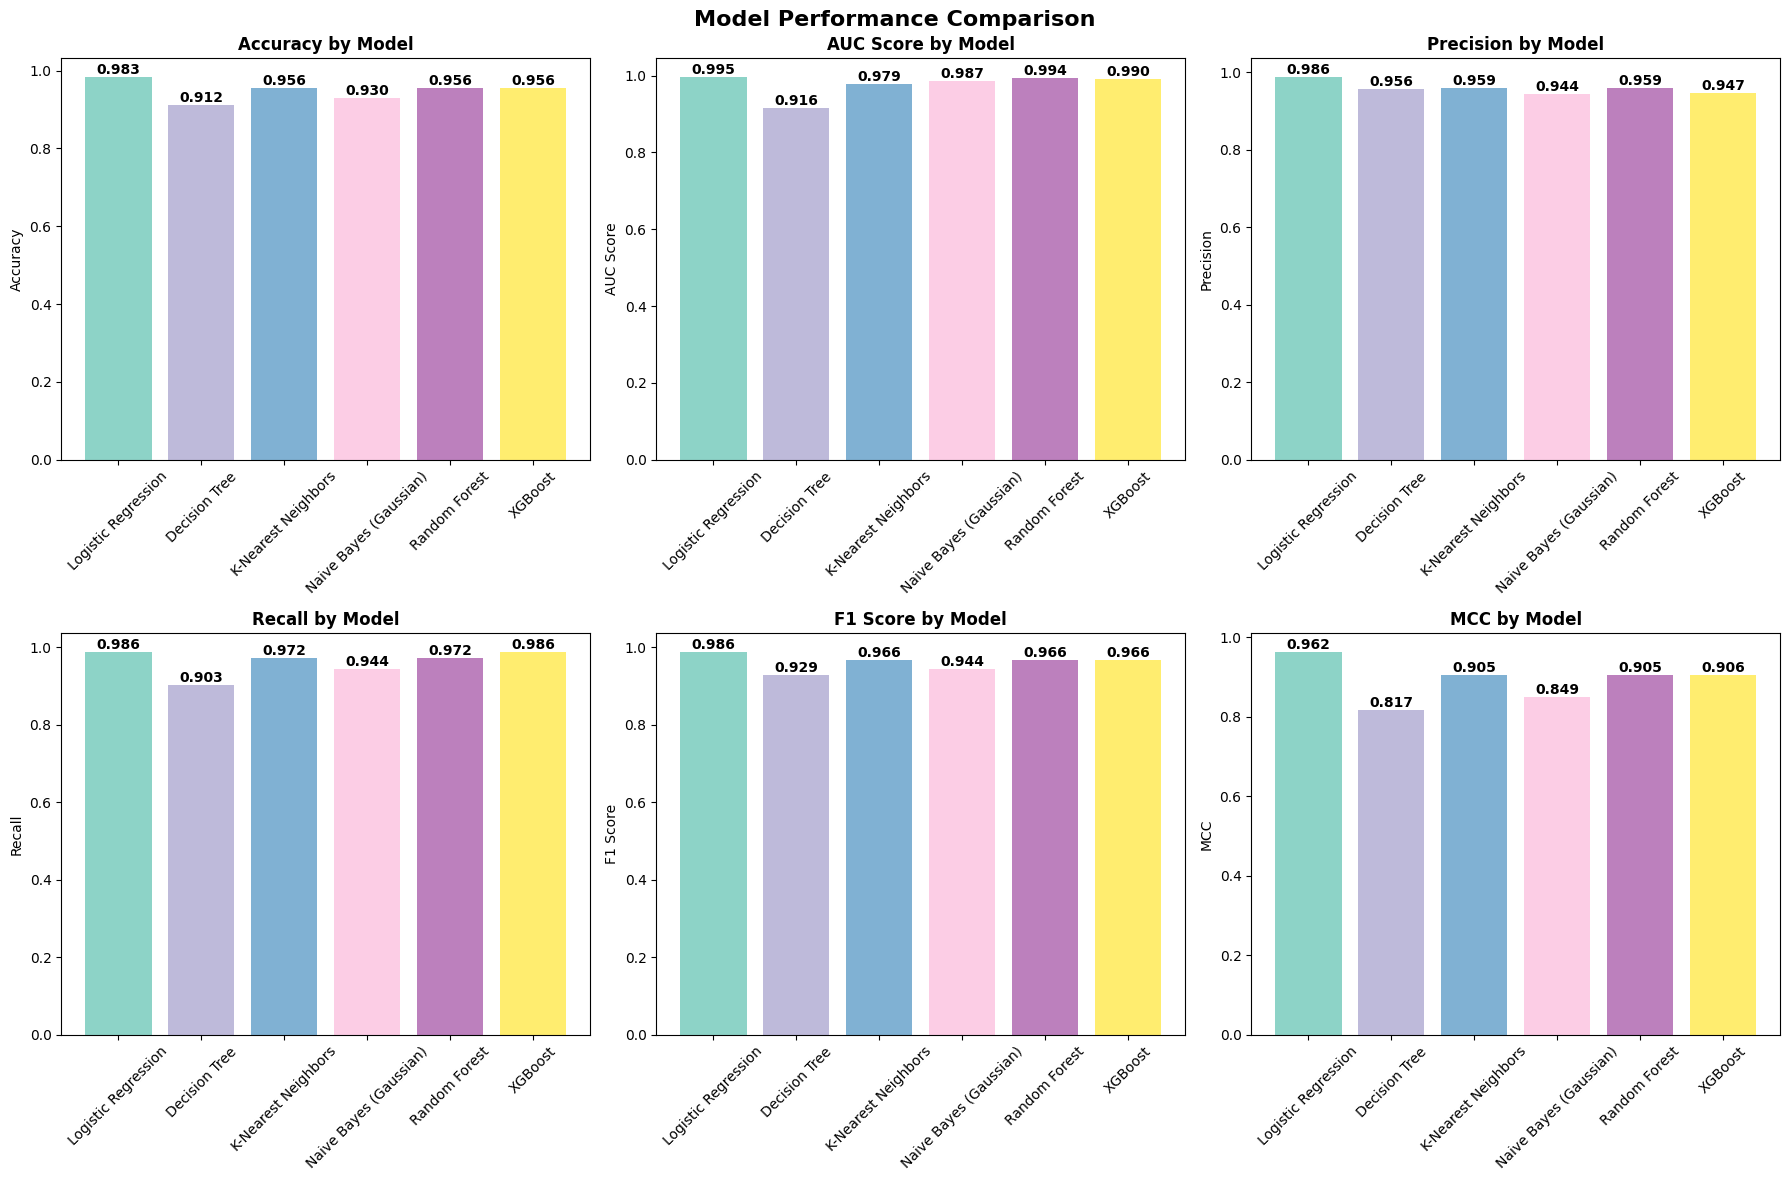

In [53]:
# Create visualization of results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

metrics = ['Accuracy', 'AUC Score', 'Precision', 'Recall', 'F1 Score', 'MCC']
axes = axes.flatten()

for i, metric in enumerate(metrics):
    if metric == 'AUC Score':
        # Handle AUC score which might have N/A values
        plot_data = results_df[results_df[metric] != 'N/A'].copy()
        plot_data[metric] = plot_data[metric].astype(float)
    else:
        plot_data = results_df.copy()

    if not plot_data.empty:
        bars = axes[i].bar(plot_data['Model'], plot_data[metric],
                          color=plt.cm.Set3(np.linspace(0, 1, len(plot_data))))
        axes[i].set_title(f'{metric} by Model', fontweight='bold')
        axes[i].set_ylabel(metric)
        axes[i].tick_params(axis='x', rotation=45)

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            axes[i].text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 7. Save Models and Preprocessors

In [54]:
# Save models and preprocessors for the Streamlit app
import joblib
import pickle

# Save fitted models
models_dict = {
    'logistic_regression': lr_fitted,
    'decision_tree': dt_fitted,
    'knn': knn_fitted,
    'naive_bayes': nb_fitted,
    'random_forest': rf_fitted,
    'xgboost': xgb_fitted
}

# Save each model
for name, model in models_dict.items():
    joblib.dump(model, f'{name}_model.pkl')
    print(f"Saved {name} model")

# Save preprocessors
joblib.dump(scaler, 'scaler.pkl')
if label_encoders:
    joblib.dump(label_encoders, 'label_encoders.pkl')
else:
    # Save empty dict for consistency
    joblib.dump({}, 'label_encoders.pkl')

# Save feature names and other metadata
metadata = {
    'feature_names': X.columns.tolist(),
    'categorical_columns': categorical_columns,
    'target_classes': ['Malignant', 'Benign'],
    'dataset_info': {
        'name': 'Breast Cancer Wisconsin',
        'source': 'UCI Machine Learning Repository (scikit-learn)',
        'n_samples': len(df),
        'n_features': len(X.columns)
    }
}

with open('metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)

print("\nAll models and preprocessors saved successfully!")
print(f"Dataset: {metadata['dataset_info']['name']}")
print(f"Features: {metadata['dataset_info']['n_features']}")
print(f"Samples: {metadata['dataset_info']['n_samples']}")
print("Ready to build Streamlit app.")

Saved logistic_regression model
Saved decision_tree model
Saved knn model
Saved naive_bayes model
Saved random_forest model
Saved xgboost model

All models and preprocessors saved successfully!
Dataset: Breast Cancer Wisconsin
Features: 30
Samples: 569
Ready to build Streamlit app.
